In [100]:
# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD

#Libraries for Saving the Model
from pickle import dump
from pickle import load


# common libraries for data engineering and machine learning tasks
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt 
import os


 # ignore warnings  
import warnings
warnings.filterwarnings('ignore')


# rectifying visualistaion's parameters to have pretty plots
font={'size': 14,
        'weight' : 'bold',
        'family':'monospace'} # weight could be book,bold etc ...
mpl.rc('font',**font)
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('lines',linewidth=5,c='black')
plt.rcParams["figure.figsize"] = (16,6)
sns.set_style('darkgrid')
# # saving visualisation function :
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join('/home/dhia/Pictures/', fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## **Problem definition:**


In the classification framework for this case study, the predicted variable is charge-off,
a debt that a creditor has given up trying to collect on after a borrower has missed
payments for several months. The predicted variable takes a value of 1 in case of
charge-off and a value of 0 otherwise.
We will analyze data for loans from 2007 to 2017Q3 from Lending Club, available on
Kaggle. Lending Club is a US peer-to-peer lending company. It operates an online
lending platform that enables borrowers to obtain a loan and investors to purchase
notes backed by payments made on these loans. The dataset contains more than
887,000 observations with 150 variables containing complete loan data for all loans
issued over the specified time period. The features include income, age, credit scores,
home ownership, borrower location, collections, and many others. We will investigate these 150 predictor variables for feature selection.

In [41]:
# load dataset
loans = pd.read_csv('/content/LoansData_sample.csv', encoding='utf-8')
loans.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39,336.64,C,C1,MANAGEMENT,10+ years,RENT,78000.0,Source Verified,Dec-2014,Fully Paid,n,NaN,debt_consolidation,Debt consolidation,235xx,VA,12.03,0.0,Aug-1994,750.0,754.0,0.0,NaN,NaN,6.0,0.0,138008.0,29.0,17.0,w,0.00,0.00,...,196500.0,149140.0,10000.0,12000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99,321.08,A,A3,Truck Driver Delivery Personel,8 years,MORTGAGE,58000.0,Not Verified,Dec-2014,Charged Off,n,NaN,credit_card,Credit card refinancing,937xx,CA,14.92,0.0,Sep-1989,710.0,714.0,2.0,42.0,NaN,17.0,0.0,6133.0,31.6,36.0,w,0.00,0.00,...,179407.0,15030.0,13000.0,11325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,37842129,NaN,21425.0,21425.0,21425.0,60 months,15.59,516.36,D,D1,Programming Analysis Supervisor,6 years,RENT,63800.0,Source Verified,Dec-2014,Fully Paid,n,NaN,credit_card,Credit card refinancing,658xx,MO,18.49,0.0,Aug-2003,685.0,689.0,0.0,60.0,NaN,10.0,0.0,16374.0,76.2,35.0,w,0.00,0.00,...,57073.0,42315.0,15000.0,35573.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,37612354,NaN,12800.0,12800.0,12800.0,60 months,17.14,319.08,D,D4,Senior Sales Professional,10+ years,MORTGAGE,125000.0,Verified,Dec-2014,Current,n,NaN,car,Car financing,953xx,CA,8.31,1.0,Oct-2000,665.0,669.0,0.0,17.0,NaN,8.0,0.0,5753.0,100.9,13.0,w,6673.54,6673.54,...,368700.0,18007.0,4400.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,37662224,NaN,7650.0,7650.0,7650.0,36 months,13.66,260.20,C,C3,Technical Specialist,< 1 year,RENT,50000.0,Source Verified,Dec-2014,Charged Off,n,NaN,debt_consolidation,Debt consolidation,850xx,AZ,34.81,0.0,Aug-2002,685.0,689.0,1.0,NaN,NaN,11.0,0.0,16822.0,91.9,20.0,f,0.00,0.00,...,82331.0,64426.0,4900.0,64031.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


####  **Data preparation and feature selection**

In [42]:
loans.describe()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,...,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,100000.000000,1.000000e+05,0.0,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,51297.000000,16732.000000,100000.000000,100000.000000,1.000000e+05,99944.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,27941.000000,100000.0,0.0,0.0,0.0,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,98044.000000,100000.000000,100000.000000,100000.000000,100000.000000,98839.000000,100000.00000,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,185.0,185.000000,185.0,185.000000,152.000000,185.000000,185.000000,1290.000000,1290.000000,1290.000000
mean,49999.500000,3.029995e+07,NaN,14886.930000,14886.930000,14883.910500,13.278073,437.331824,7.468924e+04,18.769787,0.343920,692.579800,696.579870,0.621890,33.522526,69.394215,11.832750,0.214560,1.758806e+04,55.434985,26.034860,1215.108461,1214.906467,15210.210257,15207.121685,11978.875625,3040.957018,1.230037,189.147561,31.416891,4165.111319,677.927640,664.187650,0.017010,43.451237,1.0,NaN,NaN,NaN,0.006380,...,8.662960,8.392630,15.289910,5.81747,11.790170,0.000816,0.004440,0.091430,2.095700,94.300697,50.694696,0.12654,0.056180,1.723855e+05,5.047132e+04,21073.770130,41031.318490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,110.335568,3.0,14.037838,323.495132,8046.616541,186.563135,4768.376357,47.720519,8.265116
std,28867.657797,4.763500e+06,NaN,8504.432514,8504.432514,8502.519174,4.390210,244.317648,5.809527e+04,8.539769,0.906525,29.396935,29.397299,0.913877,21.702020,27.871347,5.448006,0.585481,2.456089e+04,23.460328,12.196191,3368.209245,3367.641490,9603.208486,9601.026429,8098.533544,2936.616306,8.540185,820.822584,141.946160,6181.626479,77.841843,119.458409,0.161991,21.574189,0.0,NaN,NaN,NaN,0.087289,...,7.503737,4.505674,8.273066,3.24046,5.443067,0.028909,0.072528,0.485276,1.744647,8.422596,35.413503,0.37308,0.381058,1.798130e+05,4.816285e+04,21124.581653,42265.710848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,89.266601,0.0,9.657374,267.627244,5585.653253,168.552986,3703.963945,7.046587,8.263566
min,0.000000,5.716700e+04,NaN,1000.000000,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,0.000000,660.000000,664.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [43]:
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 151 entries, Unnamed: 0 to settlement_term
dtypes: float64(115), int64(2), object(34)
memory usage: 115.2+ MB


In [44]:
loans.shape

(100000, 151)

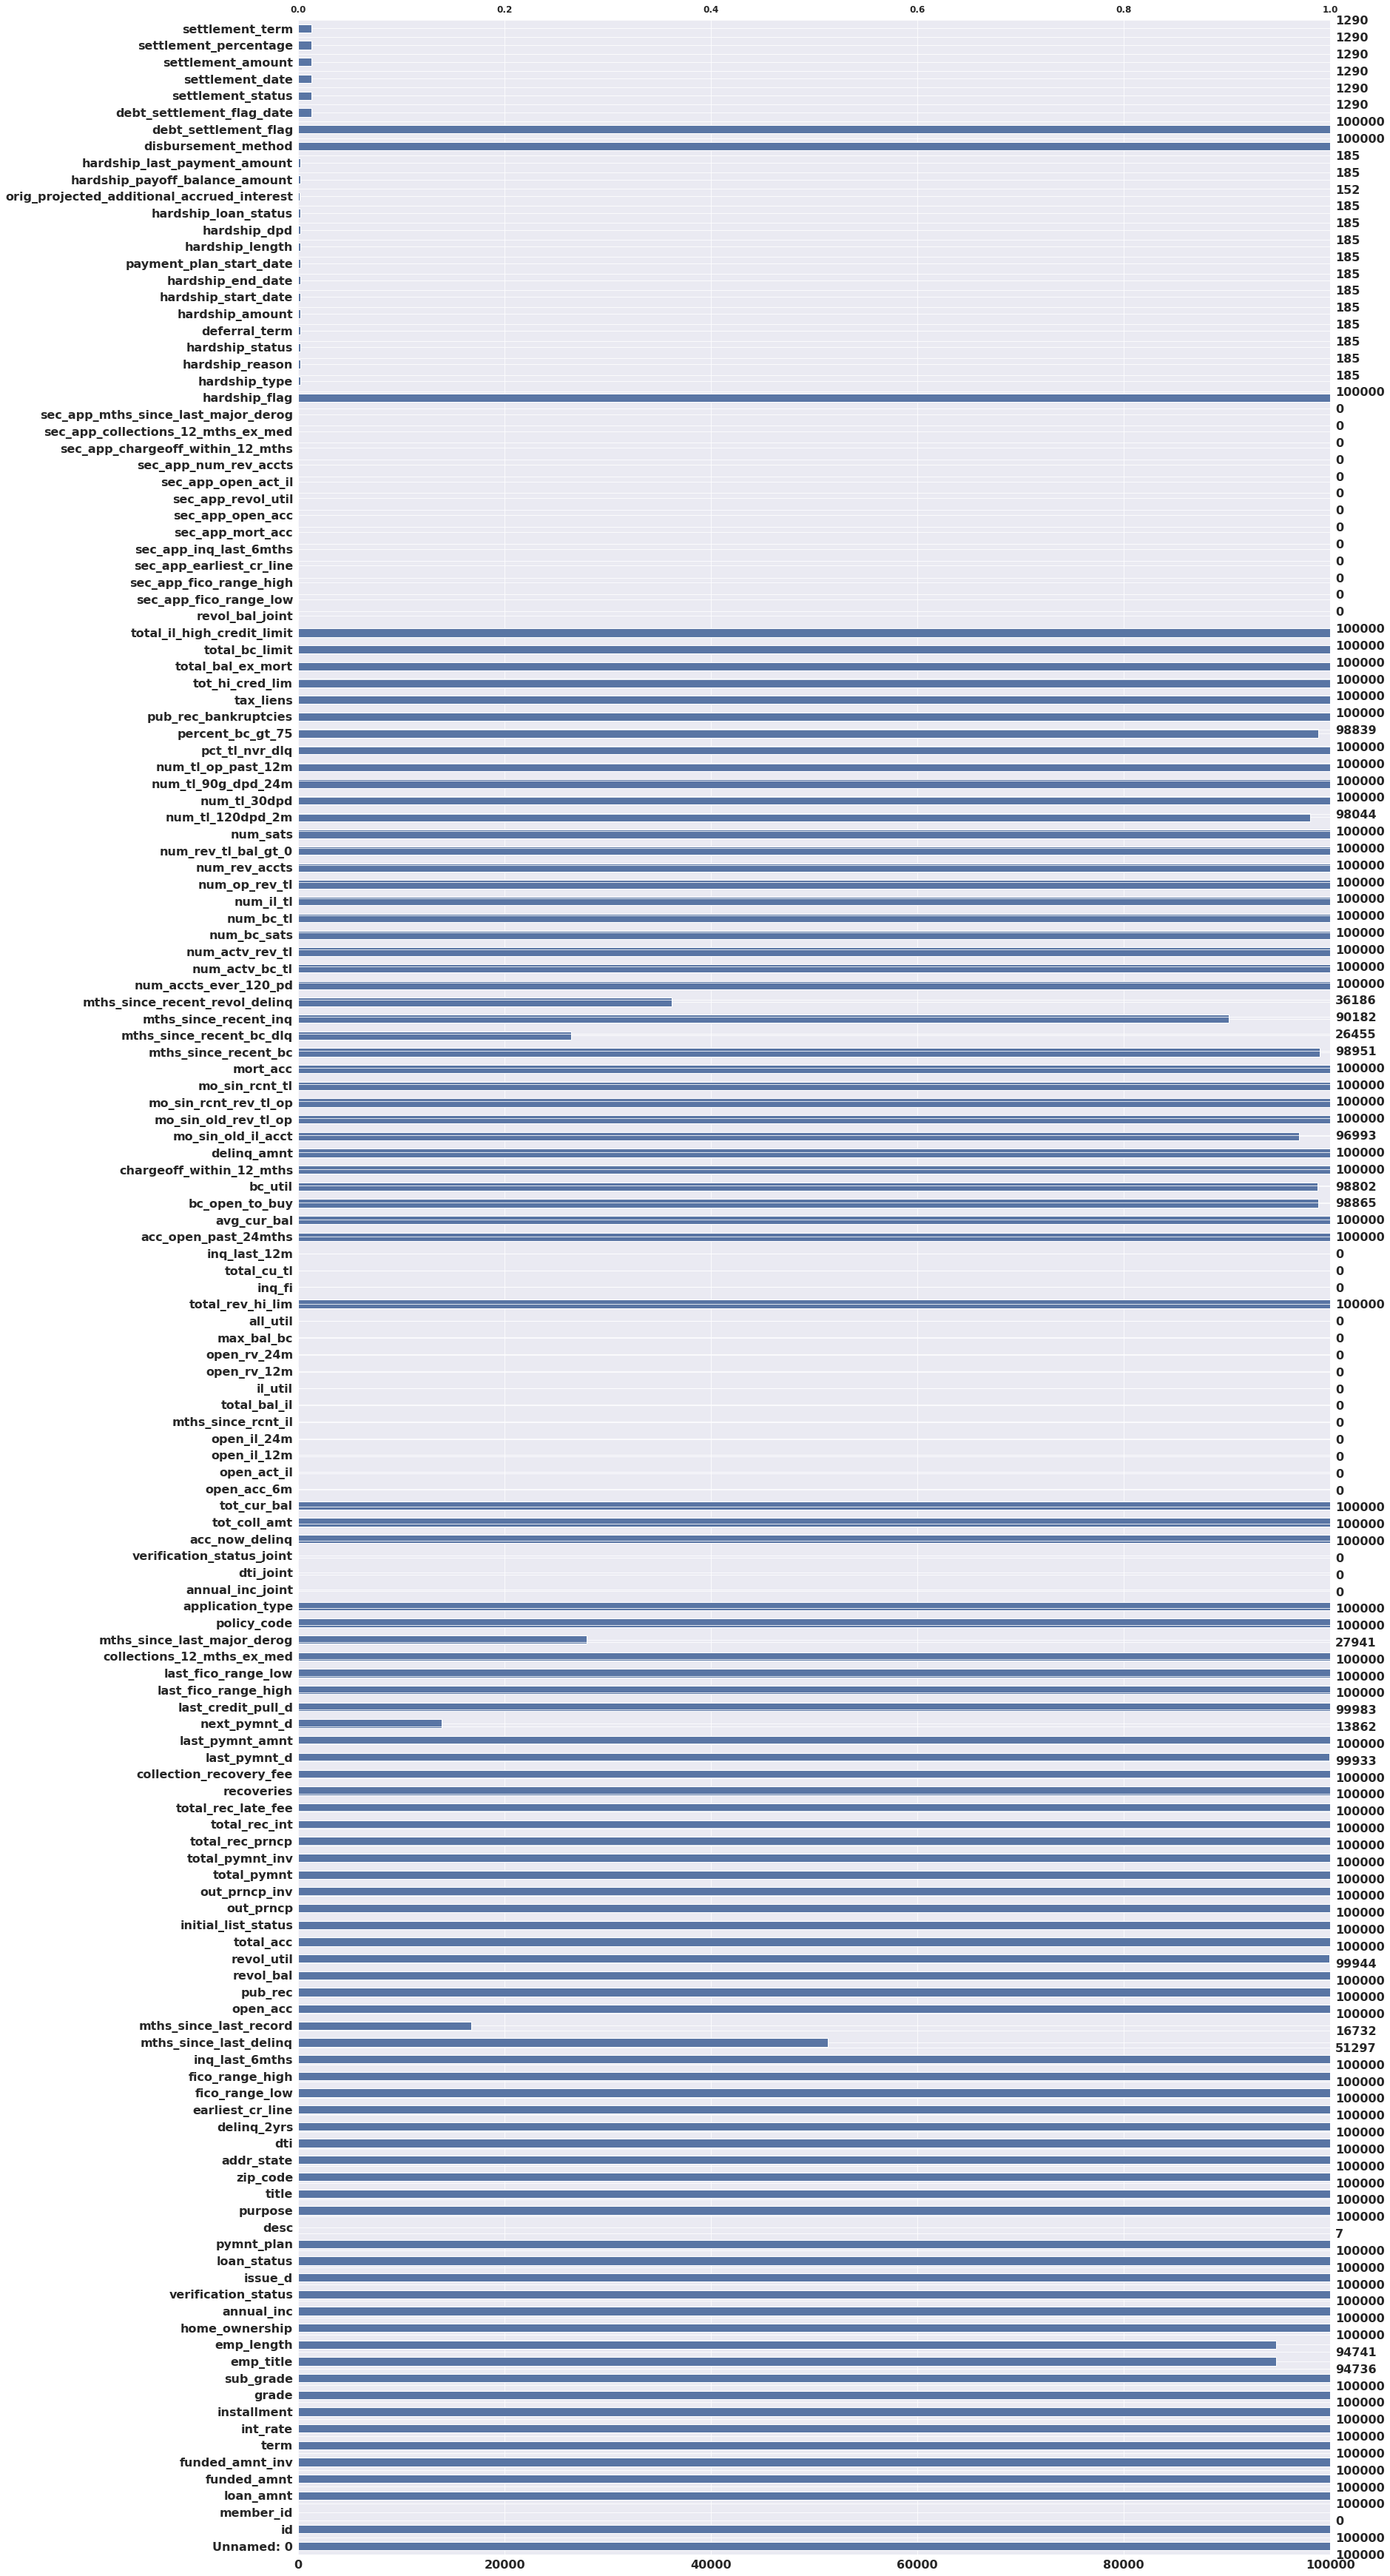

In [45]:
import missingno as msno
msno.bar(loans,color='#5975A4')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f88ac4c3c50>,
      dtype=object)

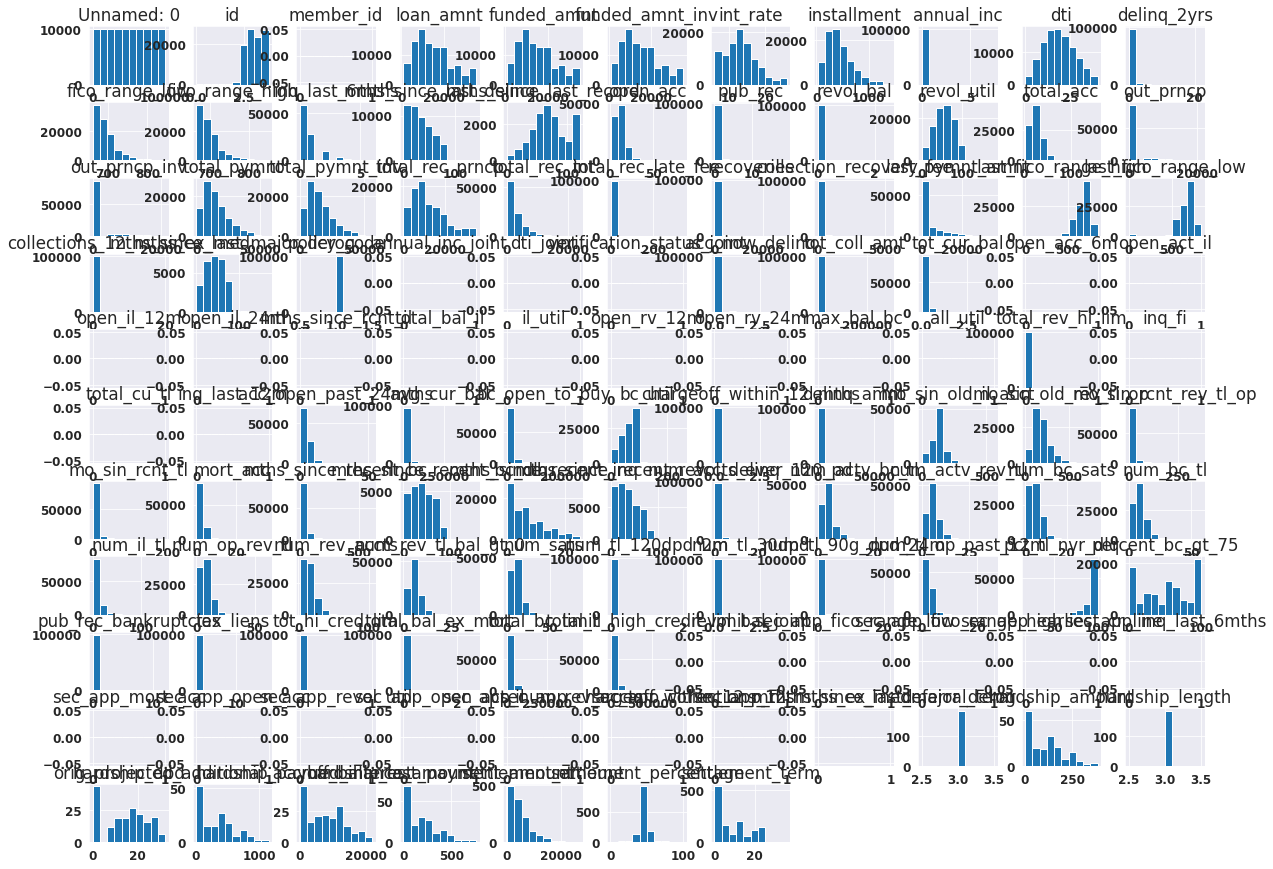

In [46]:
loans.hist(bins=10,figsize=(20,15))

Text(0.5, 1.0, 'Target Variable')

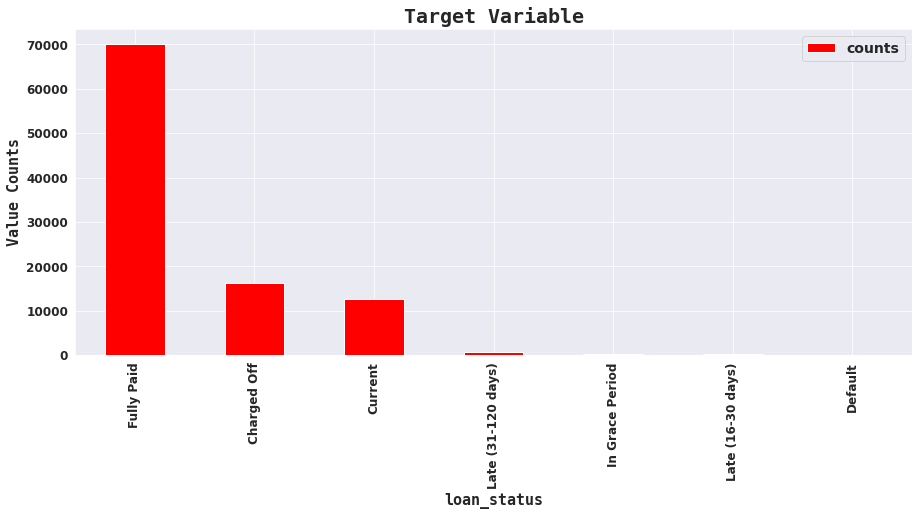

In [47]:
# Preparing the predicted variable
ax=loans['loan_status'].value_counts(dropna=False).reset_index().rename(
    columns ={'index':'amount','loan_status':'counts'}).plot(
    kind='bar',x='amount',y='counts',figsize=(15,6), color='red')
ax.set_xlabel('loan_status',fontsize=15,fontdict=font)
ax.set_ylabel('Value Counts',fontsize=15,fontdict=font)
ax.set_title('Target Variable',fontsize=20,fontdict=font)


**Fully Paid**

Loans that have been fully repaid.

**Default**

Loans that have not been current for 121 days or more.

**Charged Off**

Loans for which there is no longer a reasonable expectation of further payments.



**A large proportion of observations show a status of Current , and we do not know
whether those will be Charged Off , Fully Paid , or Default in the future. The observations for Default are tiny in number compared to Fully Paid or Charged Off and
are not considered. The remaining categories of loan status are not of prime
importance for this analysis. So, in order to convert this to a binary classification
problem and to analyze in detail the effect of important variables on the loan status,
we will consider only two major categories—Charged Off and Fully Paid:**

In [48]:
dataset=loans.copy()
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off'])]

dataset['loan_status'].value_counts(dropna=False)

dataset['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

**About 81% of the remaining loans have been fully paid and 19% have been charged
off, so we have a somewhat unbalanced classification problem**

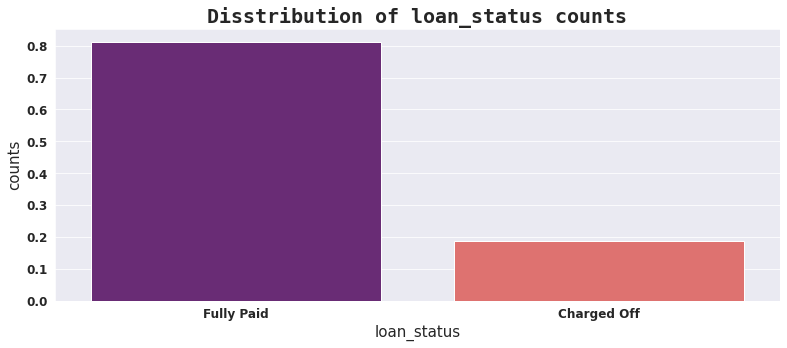

In [49]:
data2=dataset['loan_status'].value_counts(normalize=True, dropna=False).reset_index().rename(
    columns ={'index':'loan_status','loan_status':'counts'})
plt.rcParams['figure.figsize'] = (13, 5)
ax = sns.barplot(x = 'loan_status', y = 'counts', data = data2, palette = 'magma')
ax.set_xlabel(xlabel = 'loan_status', fontsize = 15)
ax.set_ylabel(ylabel = 'counts', fontsize = 15)
ax.set_title(label = 'Disstribution of loan_status counts', fontsize = 20,fontdict=font)
plt.xticks()
plt.show()

**In the next step, we create a new binary column in the dataset, where we categorize
Fully Paid as 0 and Charged Off as 1. This column represents the predicted variable
for this classification problem. A value of 1 in this column indicates the borrower has
defaulted:**

In [50]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)

#### **Feature Selection-Limit the Feature Space**

  The full dataset has 150 features for each
loan, but not all features contribute to the prediction variable. Removing features of
low importance can improve accuracy and reduce both model complexity and over‐
fitting. Training time can also be reduced for very large datasets. We’ll eliminate features in the following steps using three different approaches:


**• Eliminating features that have more than 30% missing values.**

**• Eliminating features that are unintuitive based on subjective judgment.**

**• Eliminating features with low correlation with the predicted variable.**

In [62]:
#1.Features elimination by significant missing values
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
missing_fractions.head(10)

total_cu_tl                            1.0
max_bal_bc                             1.0
sec_app_mort_acc                       1.0
sec_app_open_acc                       1.0
sec_app_revol_util                     1.0
sec_app_open_act_il                    1.0
sec_app_num_rev_accts                  1.0
sec_app_chargeoff_within_12_mths       1.0
sec_app_collections_12_mths_ex_med     1.0
sec_app_mths_since_last_major_derog    1.0
dtype: float64

In [64]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [65]:
len(drop_list)

58

In [66]:
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(86138, 93)

###2. Features elimination based on the intutiveness

In order to filter the features further we check the description in the data dictionary and keep the features that are intuitive on the basis of subjective judgement.

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:


In [67]:
print(sorted(dataset.columns))

['Unnamed: 0', 'acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_

In [68]:
keep_list = ['charged_off','funded_amnt','addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'verification_status', 'zip_code','last_pymnt_amnt','num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op','mo_sin_old_rev_tl_op',"bc_util","bc_open_to_buy","avg_cur_bal","acc_open_past_24mths" ]

len(keep_list)

40

In [69]:
drop_list = [col for col in dataset.columns if col not in keep_list]

dataset.drop(labels=drop_list, axis=1, inplace=True)

dataset.shape


(86138, 39)

In [70]:
#3. Features elimination based on the correlation
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['charged_off'])

In [73]:
data2=pd.DataFrame(correlation_chargeOff.sort_values(ascending=False)).reset_index().rename(
    columns ={'index':'Relevant features','charged_off':'correlation with target'})
data2.head()

,Relevant features,correlation with target
0,charged_off,1.000000
1,last_pymnt_amnt,0.319081
2,int_rate,0.282825
3,dti,0.123108
4,fico_range_low,0.121892


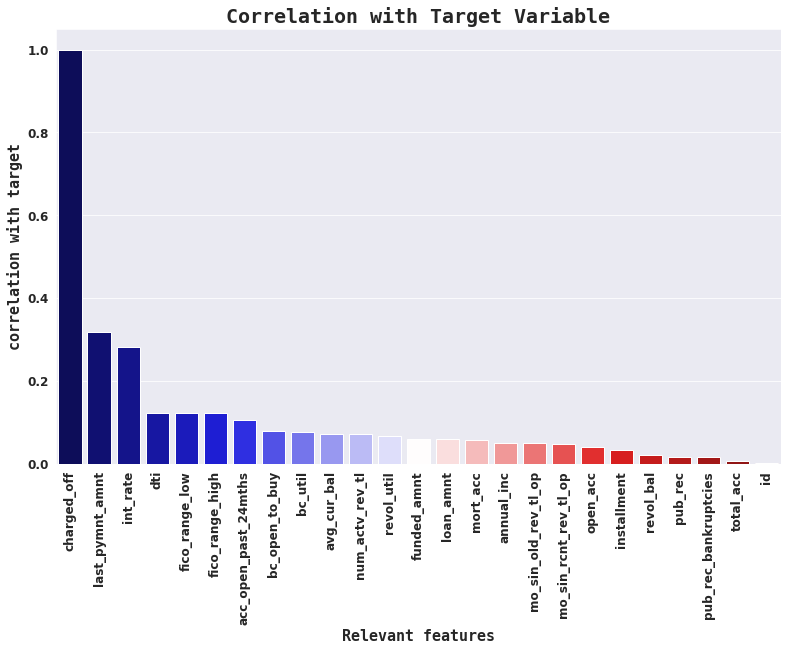

In [82]:
plt.rcParams['figure.figsize'] = (13, 8)
ax = sns.barplot(x = 'Relevant features', y = 'correlation with target', data = data2, palette = 'seismic')
ax.set_xlabel(xlabel = 'Relevant features', fontsize = 15,fontdict=font)
ax.set_ylabel(ylabel = 'correlation with target', fontsize = 15,fontdict=font)
ax.set_title(label = 'Correlation with Target Variable', fontsize = 20,fontdict=font)
plt.xticks(rotation=90)
plt.show()

In [84]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
print(drop_list_corr)

['id', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']


In [85]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape

(86138, 34)

### **4. Feature Engineering and Exploratory Analysis**

In this step, we perform the exploratory data analysis of the feature selection. Given
that many features had to be eliminated, it is preferable that we perform the explora‐
tory data analysis after feature selection to better visualize the relevant features. We
will also continue the feature elimination by visually screening and dropping those
features deemed irrelevant.

In [90]:
dataset.describe()

,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,id
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358,0.187559,3.021246e+07
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598,0.390362,4.747838e+06
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,5.716700e+04
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000,0.000000,2.711007e+07
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000,0.000000,3.040564e+07
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000,0.000000,3.433371e+07
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000,1.000000,3.809811e+07


#### **4.1.1. Analysing the categorical features**

In [89]:
dataset['id']=loans['id']
dataset[['id','emp_title','title','zip_code']].describe()


,id
count,8.613800e+04
mean,3.021246e+07
std,4.747838e+06
min,5.716700e+04
25%,2.711007e+07
50%,3.040564e+07
75%,3.433371e+07
max,3.809811e+07


In [94]:
dataset[['emp_title','title','zip_code']].describe()

,emp_title,title,zip_code
count,81416,86138,86138
unique,32987,20,846
top,Teacher,Debt consolidation,750xx
freq,1576,52990,954


**IDs are all unique and irrelevant for modeling. There are too many unique values for
employment titles and titles. Occupation and job title may provide some information
for default modeling; however, we assume much of this information is embedded in
the verified income of the customer. Moreover, additional cleaning steps on these
features, such as standardizing or grouping the titles, would be necessary to extract
any marginal information. This work is outside the scope of this case study but could
be explored in subsequent iterations of the model.
Geography could play a role in credit determination, and zip codes provide a granu‐
lar view of this dimension. Again, additional work would be necessary to prepare this
feature for modeling and was deemed outside the scope of this case study.**


In [95]:
dataset.drop(['id','emp_title','title','zip_code'], axis=1, inplace=True)

In [96]:
#Feature : Term

#Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60.". 
#The 60 Months loans are more likelely to charge off
#Convert term to integers
dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))

In [97]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

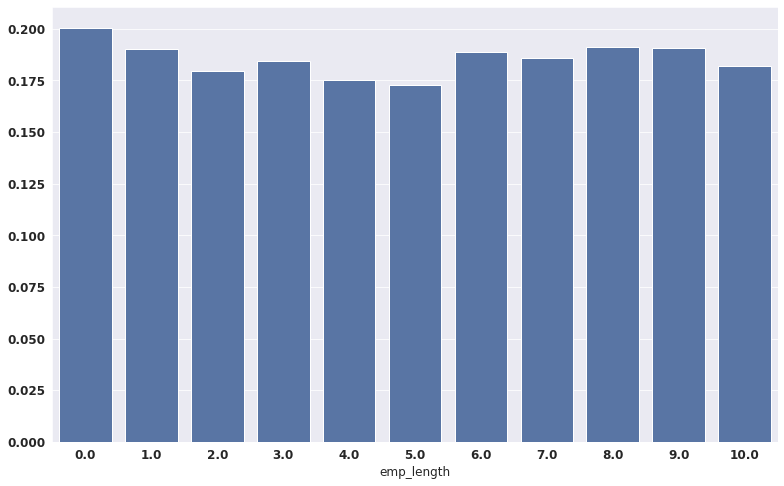

In [98]:
#Feature- Employement Length

dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)

dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)

def emp_length_to_int(s):
    if pd.isnull(s):
        return s
    else:
        return np.int8(s.split()[0])
    
dataset['emp_length'] = dataset['emp_length'].apply(emp_length_to_int)

charge_off_rates = dataset.groupby('emp_length')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)



In [101]:
#Loan status does not appear to vary much with employment length on average, hence it is dropped
dataset.drop(['emp_length'], axis=1, inplace=True)

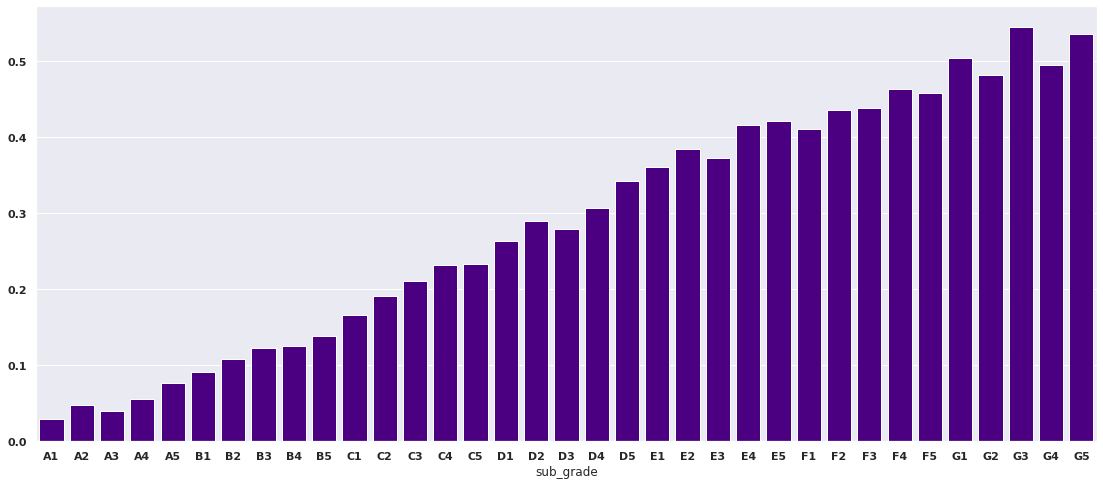

In [107]:
#Feature : Subgrade
charge_off_rates = dataset.groupby('sub_grade')['charged_off'].value_counts(normalize=True).loc[:,1]
sns.set(rc={'figure.figsize':(19,8)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='indigo', saturation=1)


In [108]:
#There's a clear trend of higher probability of charge-off as the subgrade worsens.
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))

### **4.1.2. Analysing the continuous features**

Feature : Annual Income

In [109]:
dataset[['annual_inc']].describe()

,annual_inc
count,8.613800e+04
mean,7.384311e+04
std,5.929352e+04
min,4.000000e+03
25%,4.500000e+04
50%,6.247372e+04
75%,9.000000e+04
max,7.500000e+06


In [110]:
#Annual income ranges from 0 to 9,550,000, with a median of $65,000. Because of the large range of incomes, we should take a log transform of the annual income variable
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x+1))
dataset.drop('annual_inc', axis=1, inplace=True)


In [111]:
#FICO Scores

dataset[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


In [112]:
#Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores
dataset['fico_score'] = 0.5*dataset['fico_range_low'] + 0.5*dataset['fico_range_high']

dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)

dataset['charged_off'].value_counts()



0    69982
1    16156
Name: charged_off, dtype: int64

### **4.2. Encoding Categorical Data**

In [113]:
from sklearn.preprocessing import LabelEncoder

# Categorical boolean mask
categorical_feature_mask = dataset.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = dataset.columns[categorical_feature_mask].tolist()

categorical_cols



['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [114]:
le = LabelEncoder()
# apply le on categorical feature columns
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda col: le.fit_transform(col))
dataset[categorical_cols].head(10)


,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,2,10,3,1,2,40,1,0
1,0,2,1,0,1,4,1,0
2,3,15,3,1,1,21,1,0
4,2,12,3,1,2,3,0,0
5,2,12,3,1,2,26,0,0
6,1,9,1,1,3,20,0,0
7,1,8,2,2,2,40,1,0
8,2,13,3,1,1,42,0,0
9,1,8,3,0,2,18,0,0
10,1,9,3,2,2,19,0,0


In [115]:
dataset.shape

(86138, 29)

### **4.3. Sampling Data**

In [116]:
loanstatus_0 = dataset[dataset["charged_off"]==0]
loanstatus_1 = dataset[dataset["charged_off"]==1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print("Current shape of dataset :",dataset.shape)
dataset.head()

Current shape of dataset : (11000, 29)


,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,dti,earliest_cr_line,open_acc,revol_util,initial_list_status,last_pymnt_amnt,application_type,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off,log_annual_inc,fico_score
0,7125.0,7125.0,36,10.99,233.23,1,7,3,0,2,25,26.50,2008,12.0,84.1,1,251.78,0,2.0,4156.0,825.0,87.3,70.0,26.0,0.0,3.0,1,4.494169,662.0
1,3000.0,3000.0,36,6.03,91.31,0,0,3,0,2,29,7.50,2008,11.0,36.2,0,2558.62,0,3.0,6963.0,5533.0,38.5,71.0,13.0,0.0,2.0,0,4.875067,732.0
2,10000.0,10000.0,36,9.17,318.79,1,5,1,0,2,17,6.84,1984,8.0,43.0,0,6766.51,0,3.0,29057.0,8261.0,47.4,367.0,16.0,4.0,3.0,0,4.568213,692.0
3,12000.0,12000.0,60,17.86,303.81,3,19,3,2,2,4,18.95,2004,11.0,59.1,1,303.81,0,8.0,3854.0,4640.0,78.1,124.0,4.0,0.0,8.0,1,4.740371,662.0
4,33575.0,33575.0,36,12.49,1123.05,1,9,3,2,2,38,38.92,1986,17.0,46.8,0,21459.90,0,3.0,7533.0,28807.0,49.2,340.0,12.0,1.0,6.0,0,5.096913,717.0


In [117]:
#Filling the NAs with the mean of the column.
dataset.fillna(dataset.mean(),inplace = True)

## **5. Evaluate Algorithms and Models**

5.1. Train Test Split


In [118]:
# split out validation dataset for the end
Y= dataset["charged_off"]
X = dataset.loc[:, dataset.columns != 'charged_off']
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# dataset_temp2=dataset_temp.dropna(axis=0)
# Y_total= dataset_temp2["charged_off"]
# X_total = dataset_temp2.loc[:, dataset.columns != 'charged_off']
# X_dummy, X_validation, Y_dummy, Y_validation = train_test_split(X_total, Y_total, test_size=validation_size)

dataset['charged_off'].value_counts()



1    5500
0    5500
Name: charged_off, dtype: int64

In [119]:
# test options for classification
num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'


**Compare Models and Algorithms**

In [120]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models 
# Boosting methods
models.append(('AdB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))



**K-folds cross validation**

In [122]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.908907 (0.007819)
LDA: 0.905925 (0.007338)
KNN: 0.825452 (0.012540)
CART: 0.808994 (0.011424)
NB: 0.904498 (0.010570)
NN: 0.874293 (0.022300)
AB: 0.930984 (0.006726)
GBM: 0.940961 (0.006106)
RF: 0.934261 (0.007720)
ET: 0.925207 (0.007236)


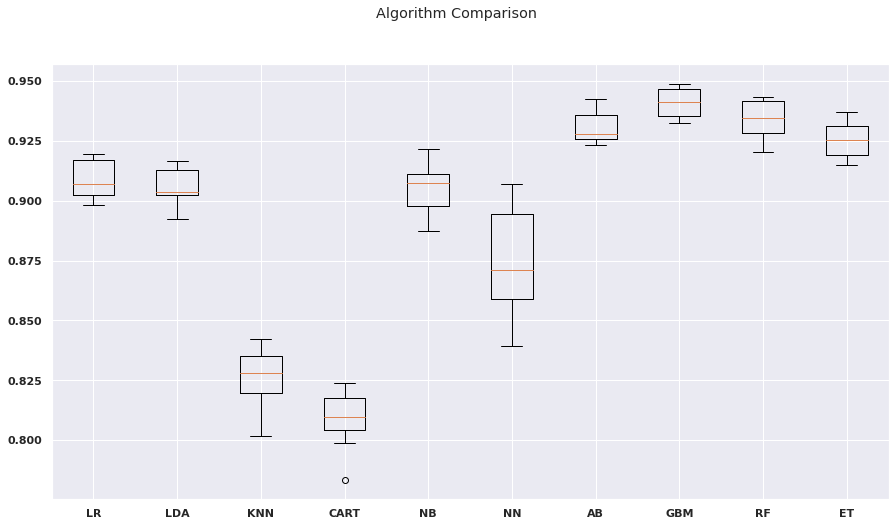

In [125]:
# compare algorithms
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()


### **6. Model Tuning and Grid Search**

Given that the GBM is the best model, Grid Search is performed on GBM in this step.


In [127]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 
n_estimators = [20,180]
max_depth= [3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.940666 using {'max_depth': 3, 'n_estimators': 180}
#4 0.931243 (0.006719) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.940666 (0.007585) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.935977 (0.007132) with: {'max_depth': 5, 'n_estimators': 20}
#2 0.940364 (0.007818) with: {'max_depth': 5, 'n_estimators': 180}


#### **7. Finalise the Model**

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

**7.1. Results on the Test Dataset**

In [128]:
# prepare model
model = GradientBoostingClassifier(max_depth= 3, n_estimators= 180)
model.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=180)

In [129]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8563636363636363
[[ 860  225]
 [  91 1024]]
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1085
           1       0.82      0.92      0.87      1115

    accuracy                           0.86      2200
   macro avg       0.86      0.86      0.86      2200
weighted avg       0.86      0.86      0.86      2200



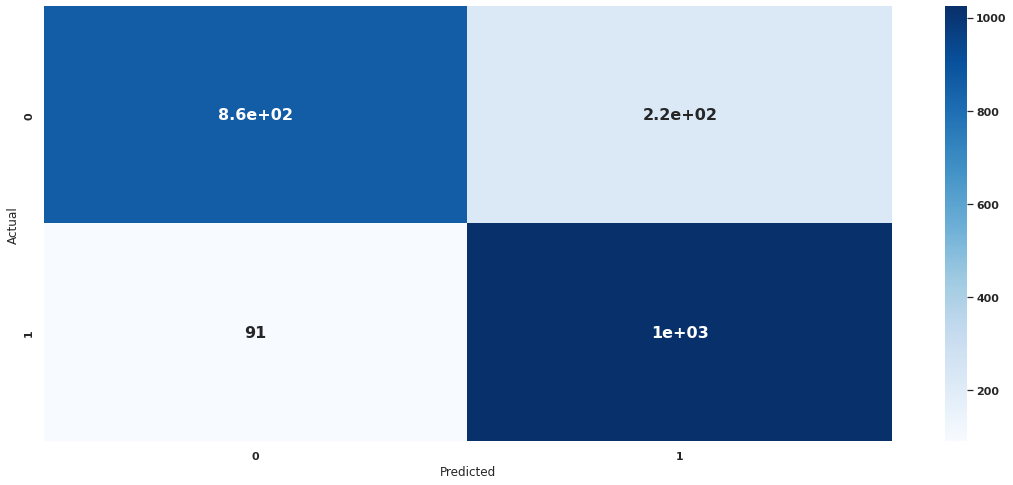

In [130]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

**7.2. Variable Intuition/Feature Importance**

Looking at the details above GBM might be worthy of further study. Let us look into the Feature Importance of the GBM model

[6.08571999e-03 3.24842631e-03 1.14772339e-01 4.40172303e-02
 2.43671009e-02 1.07473668e-02 9.46474569e-03 3.10424922e-04
 1.95712201e-03 1.05540624e-03 1.68734487e-03 4.69318680e-03
 2.37572629e-03 1.02537280e-03 2.95585990e-03 1.65240111e-04
 7.28855983e-01 0.00000000e+00 1.31635952e-02 2.97656916e-03
 5.28542948e-03 3.36999254e-03 3.45923411e-03 3.19473755e-03
 5.41707042e-04 1.64715714e-03 4.83171943e-03 3.74526172e-03]


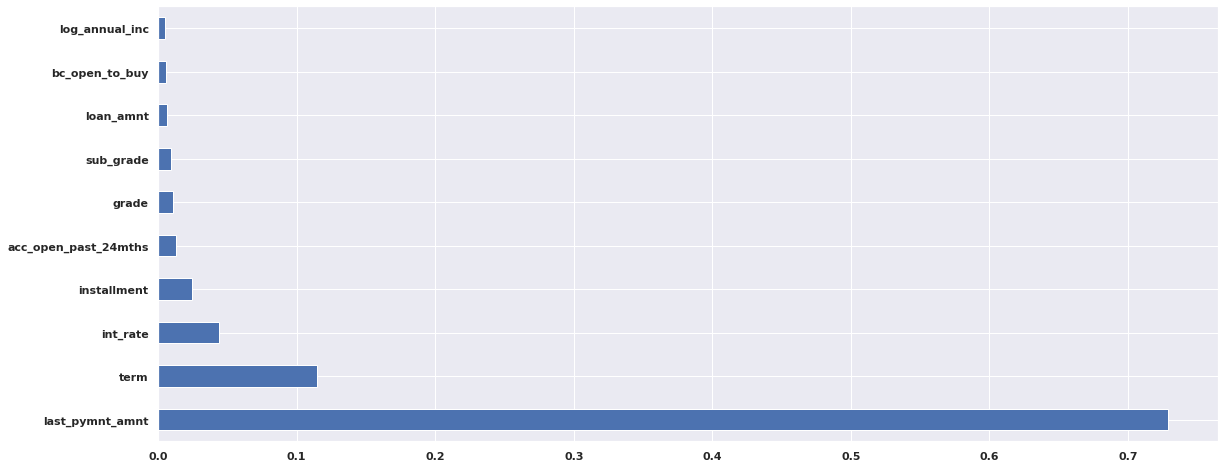

In [131]:
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

**Conclusion:**

We showed that data preparation is one of the most important steps. We addressed that by performing feature elimination by using different techniques such as subjec‐ tive judgement, correlation, visualization and the data quality of the feature. We illustrated that there can be different ways of handling and analyzing the categorical data and converting categorical data into model usable format.

Finally, we analyzed the feature importance and found that results of the case study are quite intuitive.
